<a href="https://colab.research.google.com/github/sridhars03/stella_vslam_benchmark_fusion_/blob/main/src/stella_vslam/fusion/RNN_try2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#To try:
'''
smaller LSTM layer
different sequence lengths
different dropout values
include learning rate?
'''

'\nsmaller LSTM layer\ndifferent sequence lengths\ndifferent dropout values\ninclude learning rate?\n'

In [ ]:
#IMPORTS
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from sklearn.model_selection import train_test_split
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#################
#GT

#make a case to ignore first row if there is string
def read_ground_truth(file_path):
    data = np.loadtxt(file_path)
    data = data[:,1:]
    return data

ground_truth = read_ground_truth('/content/drive/MyDrive/GEData/data.tum')
print(ground_truth[:2])

[[ 0.878612  2.14247   0.947262 -0.828459 -0.058956 -0.553641  0.060514]
 [ 0.878658  2.142398  0.947252 -0.828433 -0.059051 -0.553664  0.060571]]


In [ ]:
#################
#SLAM trajectory outputs
#************Synchronized trajs*********

def read_traj_outputs(file_path):
    data = np.loadtxt(file_path)
    data = data[:,1:]
    return data

In [ ]:
#TRAINING INPUT DATA
#without the timestamps
# Replace with the paths to your trajectory output files in Google Drive
poses_orb = read_traj_outputs('/content/drive/MyDrive/GEData/synchronized_trajectory_orb.txt')  #orb
poses_openvslam = read_traj_outputs('/content/drive/MyDrive/GEData/synchronized_trajectory_openvslam.txt')  #openvslam
print(poses_orb[:2],poses_openvslam[:2])

#GT ll have different size. how to sync GT with these 2??
#actual method: before doing synchronizing, check which has smaller size-then sync with that traj.txt
#confusion with usual CNN - train bunch of imgs (input)-target-label.
#here - train one big traj file - target-also traj file, when I train with another set of traj vs GT, will it undo the prev training?

[[ 1.40371528e+09 -4.85362000e-03 -3.72603910e-02  1.00638820e-02
   2.78241130e-02  3.44173100e-03  1.04273810e-02  9.99552548e-01]
 [ 1.40371528e+09 -5.35651800e-03 -4.48795820e-02  1.04846140e-02
   3.25517950e-02  2.42477800e-03  1.15553960e-02  9.99400377e-01]] [[ 1.40371528e+09 -5.84083149e-03 -4.12494407e-02  1.09020021e-02
   2.73515627e-02  3.30149928e-03  9.67261489e-03  9.99573625e-01]
 [ 1.40371528e+09 -6.47993811e-03 -5.11560346e-02  1.19780713e-02
   3.12120984e-02  2.52622235e-03  1.11102391e-02  9.99447840e-01]]


In [ ]:
#*******************SYNC GT WITH Traj.txt

def read_trajectory(file_path):
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, dtype={0: float})
    data.columns = ['timestamp', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw']
    return data

def find_nearest_unique_timestamps(reference_timestamps, target_timestamps):
    # Initialize an array to store the indices of the nearest unique timestamps
    nearest_indices = []
    used_indices = set()

    for ref_time in reference_timestamps:
        # Calculate the absolute differences between the reference timestamp and all target timestamps
        differences = np.abs(target_timestamps - ref_time)

        # Mask out the already used indices by setting their differences to a large number
        differences[list(used_indices)] = np.inf

        # Find the index of the minimum difference
        nearest_index = np.argmin(differences)
        nearest_indices.append(nearest_index)

        # Mark this index as used
        used_indices.add(nearest_index)

    return nearest_indices

# Replace 'synchronized_trajectory_orb.txt' and 'synchronized_trajectory_openvslam.txt' with your actual file paths
trajectory_openvslam = read_trajectory('/content/drive/MyDrive/GEData/synchronized_trajectory_openvslam.txt')
trajectory_gt = read_trajectory('/content/drive/MyDrive/GEData/data.tum')

# Extract timestamps
timestamps_gt = trajectory_gt['timestamp'].values
timestamps_openvslam = trajectory_openvslam['timestamp'].values

# Find nearest timestamps in OpenVSLAM for ORB-SLAM3 timestamps
nearest_indices = find_nearest_unique_timestamps(timestamps_openvslam,timestamps_gt)

synchronized_gt = trajectory_gt.iloc[nearest_indices].reset_index(drop=True)
# Save it
synchronized_gt.to_csv('/content/drive/MyDrive/GEData/synchronized_gt.txt', sep=' ',header=False,index=False)
print("**************")

#assert method to check for size matching btwn trajs and GT
assert synchronized_gt.shape[0] == poses_orb.shape[0] == poses_openvslam.shape[0], "Mismatch in number of samples"

synchronized_gt_numpy = synchronized_gt.to_numpy()    #changning pandas DF to numpy

**************


In [ ]:
train_input_traj = np.concatenate((poses_orb, poses_openvslam), axis=1) #without timestamps
target_input_traj = synchronized_gt_numpy[:,1:]  #without timestamps
print(target_input_traj.shape, train_input_traj.shape)

# SEQUENCE FOR LSTM
sequence_length = 5
num_sequences = train_input_traj.shape[0] - sequence_length
X = np.array([train_input_traj[i:i+sequence_length] for i in range(num_sequences)])
y = np.array([target_input_traj[i+sequence_length] for i in range(num_sequences)])
print(X.shape,y.shape)

(2801, 7) (2801, 16)
(2796, 5, 16) (2796, 7)


In [ ]:
# DEFINE MODEL + TRAIN
X_train, X_val, y_train, y_val = X[:int(0.9*num_sequences)], X[int(0.9*num_sequences):], y[:int(0.9*num_sequences)], y[int(0.9*num_sequences):]
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)
model = Sequential([LSTM(128, return_sequences=False, input_shape=(sequence_length, 7*2)),
                    Dropout(0.2),
                    Dense(7,activation='relu')])

model.compile(optimizer='adam', loss='mse')     #give accuracy/metrics here

#***************ADD early stopping, dropout, try different activation--
# early_stopping = EarlyStopping(min_delta=0.008, monitor='val_loss', patience=10 ,restore_best_weights=True)

model.summary()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),verbose=1)

(2516, 5, 16) (280, 5, 16) (2516, 7) (280, 7)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 128)                 │          73,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,119 (289.53 KB)

 Trainable params: 74,119 (289.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 16 and 14 for '{{node sequential_10_1/lstm_10_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_10_1/lstm_10_1/strided_slice_2, sequential_10_1/lstm_10_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,16], [14,512].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 16), dtype=float32)
  • states=('tf.Tensor(shape=(None, 128), dtype=float32)', 'tf.Tensor(shape=(None, 128), dtype=float32)')
  • training=True

Index(['loss', 'val_loss'], dtype='object')
Loss= 0.2682581901550293      Val Loss= 0.07837518647313119


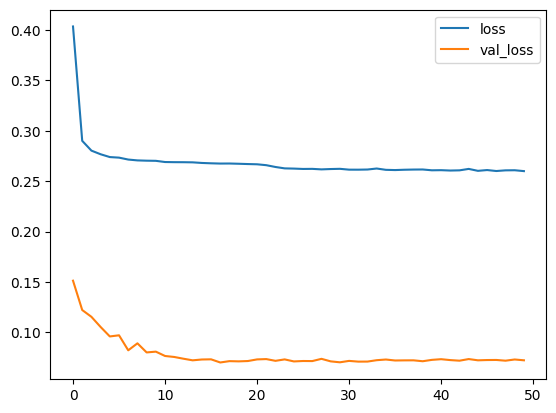

In [ ]:
#VIZ - loss, accuracy plots
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print(history_df.columns)
print("Loss=",history_df['loss'].mean(), "     Val Loss=",history_df['val_loss'].mean())
# history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()
# print(("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}").format(history_df['val_loss'].min(),history_df['val_binary_accuracy'].max()))

In [ ]:
#GETTING TEST DATA
#************Synchronized trajs*********

#Trying to get a better traj output from this RNN model
#testing with v102 trajectory now
test_traj_orb = read_traj_outputs('/content/drive/MyDrive/GEData/synchronized_trajectory_orb_mh01test.txt')
test_traj_openvslam = read_traj_outputs('/content/drive/MyDrive/GEData/synchronized_trajectory_openvslam_mh01test.txt')
print(test_traj_orb.shape)
#*****Think about the (sequence length,7) shape in GPT

# Prepare sequences for testing
test_sequences = []
for i in range(len(test_traj_orb) - sequence_length + 1):
    orb_seq = test_traj_orb[i:i+sequence_length]
    openvslam_seq = test_traj_openvslam[i:i+sequence_length]
    combined_seq = np.concatenate((orb_seq, openvslam_seq), axis=1)
    test_sequences.append(combined_seq)

test_sequences = np.array(test_sequences)
print(test_sequences.shape)  #(num_test_sequences,sequence_length,14)

(3038, 7)
(3034, 5, 14)


In [ ]:
# PREDICTION OF TRAJECTORY
predicted_traj = model.predict(test_sequences)
print(predicted_traj.shape)   # (num of samples - seq length + 1, 7)
print(predicted_traj[0])

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
(3034, 7)
[0.74801946 1.9828956  0.7667477  0.         0.         0.
 0.07406384]


In [ ]:
#*********mimic timestamps n add to result traj
#for now - i ll use timestamp of openvslam..

def read_traj_outputs(file_path):
    data = np.loadtxt(file_path)
    return data


test_openvslam_with_timestamps = read_traj_outputs('/content/drive/MyDrive/GEData/synchronized_trajectory_openvslam_mh01test.txt')
avg_timegap=(test_openvslam_with_timestamps[-1][0] - test_openvslam_with_timestamps[0][0])/(test_openvslam_with_timestamps.shape[0]-1)
fake_timestamp = np.arange(test_openvslam_with_timestamps[0][0],test_openvslam_with_timestamps[0][0]+predicted_traj.shape[0]*avg_timegap,avg_timegap).reshape(-1,1)
result_with_timestamps = np.hstack((fake_timestamp,predicted_traj))

#save the result traj
np.savetxt('/content/drive/MyDrive/GEData/Resultmh01.txt', result_with_timestamps,delimiter=' ', fmt='%f')